## Project Overview



## Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
from __future__ import annotations

# Set the working directory to the project root
project_root = Path().resolve().parent
os.chdir(project_root)

# import local modules
import prospectivity_tools as pt

In [2]:
# todo--delete??

# Step 1: Define paths
parquet_path = Path(pt.settings.paths["parquet"])
html_path = Path(pt.settings.paths["interactive_html"])

# Step 2: Handle existing files
overwrite = True  # Set to True if you want to overwrite existing outputs
skip_existing = False  # Set to True if you want to skip processing if dataset_descriptions exist

if (parquet_path.exists() or html_path.exists()) and not overwrite:
    if skip_existing:
        gdf_cols_description("gdf_cols_descriptions already exist, skipping")
    else:
        raise Exception("gdf_cols_description files exist. Use overwrite=True or skip_existing=True.")


In [3]:
# Read in geopackage
gdf = gpd.read_file(pt.settings.paths["input_gpkg"], engine="pyogrio").to_crs(pt.settings.crs)

In [4]:
# gdf.explore()

In [ ]:
# print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gid         1596 non-null   float64 
 1   upid        1596 non-null   object  
 2   area_m2     1596 non-null   float64 
 3   strat_unit  1596 non-null   object  
 4   era         1596 non-null   object  
 5   period      1596 non-null   object  
 6   strat_age   1596 non-null   object  
 7   strat_name  1184 non-null   object  
 8   gp_suite    1036 non-null   object  
 9   fm_lithodm  443 non-null    object  
 10  mem_phase   76 non-null     object  
 11  rock_class  1596 non-null   object  
 12  rock_type   1596 non-null   object  
 13  rk_char     2 non-null      object  
 14  unit_desc   1596 non-null   object  
 15  age_max     1596 non-null   object  
 16  age_min     1596 non-null   object  
 17  belt        1596 non-null   object  
 18  terrane     1596 non-null   object  
 19

In [11]:
# gdf_cols_description = pt.df_more_info(gdf)
# print(gdf_cols_description)

# Notes: 
Good columns: 

    -upid--unique
    -area_m2--min 9322 max much bigger

questions

    -era
    -gid
    -strat_unit
    -period
    -strat_age
    -strat_name
    -gp_suite

In [7]:
# from llama_index.llms.openai import OpenAI
# from llama_index.core import Settings

# # Initialize the LLM
# llm = OpenAI(model="gpt-4o", temperature=0)

# # Set the LLM in global settings
# Settings.llm = llm

# prompt = f"""
# Describe the columns in the geopandas dataframe in plain english: 
# {str(gdf_cols_description + str(gdf.info()))[0:1000]} 
# Here is the complete info. Discuss your interpretation of what they mean. 
# Use regular line breaks in your response (encode wrapping) """

# # Input a string and get a string back
# response = llm.complete(prompt)
# print(response)

# ## Todo, finish and make clean

# Todo: clean up

Essential / high‑leverage columns
- geometry: shape data needed to calculate distances and overlays
- rock_type: specific lithology (e.g. granodiorite, ultramafic) used for proximity scoring
- rock_class: general rock group (e.g. sedimentary, metamorphic); useful backup
- unit_desc: full-text description with keywords like "serpentinite" or "granodiorite"
- strat_name: formal stratigraphic name; useful if rock_type is missing
- gp_suite: geological suite name; often overlaps with strat_name
- strat_unit: identifier for mapped unit; may carry lithological meaning
- area_m2: polygon area; helpful for QA on slivers or spatial joins

Potentially handy columns
- era: general geologic time range; not used directly in model
- period: finer temporal grouping; unused in this assignment
- strat_age: stratigraphic age (e.g. Upper Triassic); good for context
- age_min: minimum mapped age; not relevant to proximity rules
- age_max: maximum mapped age; same as above
- belt: tectonic belt (e.g. Coast); offers geologic context
- terrane: structural terrane (e.g. Quesnellia); useful for regional framing
- basin_age: age of basin fill; rare and unused
- rk_char: rarely used rock modifiers (e.g. “leuco”); low info content

Mostly metadata / least useful columns
- gid: numeric record ID; useful for joins only
- upid: unique hash-like ID; same as above
- project: mapping project name (e.g. “Okanagan”); not needed for modeling
- map_comp: author and date of compilation; metadata only
- src_url: link to source publication; citation only
- src_ref_s: text citation string; for documentation
- pub_org: publisher (always BCGS); not relevant to logic
- edit_date: constant value (“2018-04-05”); not informative
- basin: mostly None; no lithological utility
- mem_phase: sub-unit info; mostly empty
- fm_lithodm: formal formation info; mostly empty

In [8]:
## Todo clean up
## Feature engineering

# ------------------------------------------------------------------
# Lithology flags (ultramafic & granodiorite proximity drivers)
# ------------------------------------------------------------------
# Build a lowercase text blob for keyword searches
text_cols = ["rock_type", "unit_desc", "strat_name"]
gdf["_search"] = (
    gdf[text_cols]
    .fillna("")
    .agg(" | ".join, axis=1)
    .str.lower()
)

# Binary indicators for target lithologies
gdf["is_ultramafic"] = gdf["_search"].str.contains(
    r"(?:ultramafic|serpentinite|peridotite)"
).astype(int)

gdf["is_granodiorite"] = gdf["_search"].str.contains(
    r"\bgranodiorite\b"
).astype(int)

# ------------------------------------------------------------------
# Rock‑class back‑fill (simple heuristic)
# ------------------------------------------------------------------
class_map = {"granodiorite": "plutonic", "serpentinite": "metamorphic"}


# todo is this right??
def infer_class(row):
    if pd.isna(row["rock_class"]):
        for k, v in class_map.items():
            if k in row["_search"]:
                return v
    return row["rock_class"]

gdf["inferred_rock_class"] = gdf.apply(infer_class, axis=1)
gdf.drop(columns=["_search"], inplace=True)

# Keep track of generated columns
generated_cols = [
    "is_ultramafic",
    "is_granodiorite",
    "inferred_rock_class",
]

In [9]:
gen_columns_description = pt.df_more_info(gdf[generated_cols])
print(gen_columns_description)

Column: is_ultramafic
  Min: 0, Max: 1, Mean: 0.13972431077694236


Column: is_granodiorite
  Min: 0, Max: 1, Mean: 0.15852130325814537


Column: inferred_rock_class
  Value counts:
inferred_rock_class
sedimentary rocks    556
intrusive rocks      455
volcanic rocks       435
metamorphic rocks    104
ultramafic rocks      46
Name: count, dtype: int64





C:\Users\chris\AppData\Local\Temp\ipykernel_31932\1381564444.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ultra_union  = gdf[gdf["is_ultramafic"] == 1].geometry.unary_union
C:\Users\chris\AppData\Local\Temp\ipykernel_31932\1381564444.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grano_union  = gdf[gdf["is_granodiorite"] == 1].geometry.unary_union


Created grid with 739530 points at 500m resolution
Successfully used 10-quantile classification

Score class distribution:
score_class
0    73953
1    73953
2    73953
3    73953
4    73953
5    73953
6    73953
7    73953
8    73953
9    73953
Name: count, dtype: int64


TypeError: Legend.__init__() got an unexpected keyword argument 'shrink'

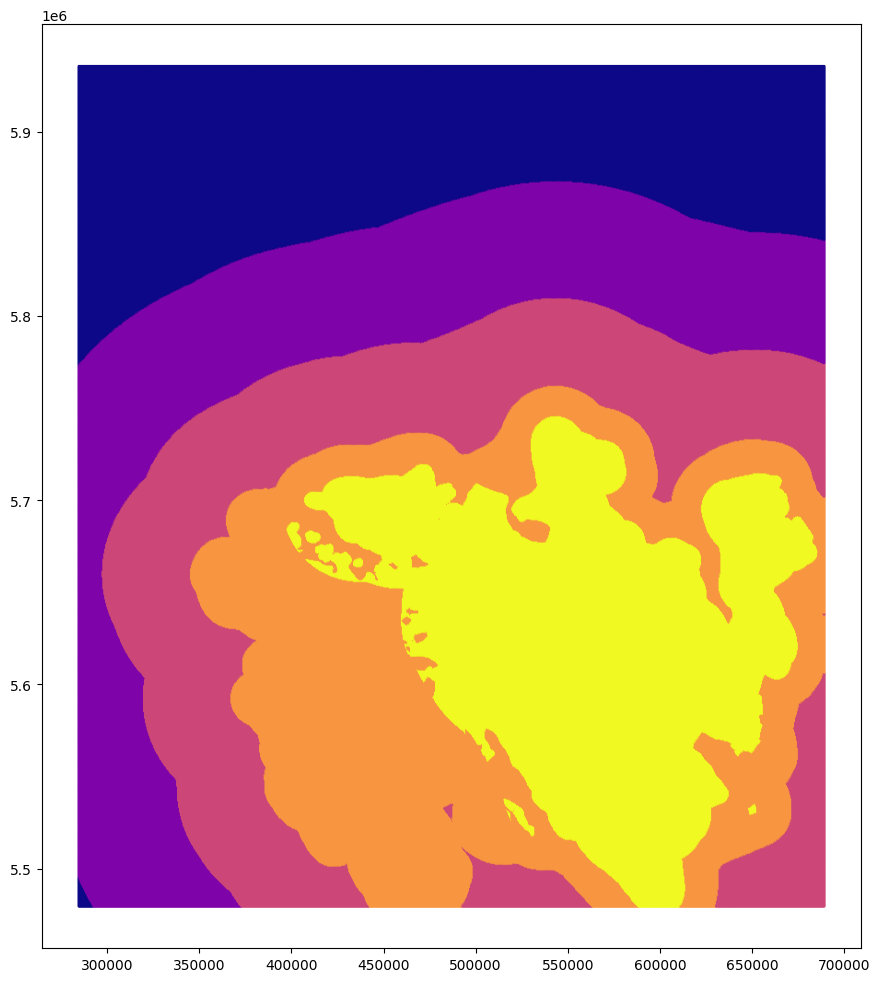

In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0.  PARAMETERS  (edit here)
# ------------------------------------------------------------------
ULTRAMAFIC_WEIGHT   = 2.0      # serpentinised / ultramafic carries most Co signal
GRANODIORITE_WEIGHT = 1.0      # fertile intrusions carry secondary weight
CELL_SIZE_M         = 500      # INCREASED RESOLUTION: 500m grid resolution for finer detail
DECAY_DISTANCE_M    = 15_000   # distance at which influence decays to ~37% (1/e)
CRS_EQUAL_AREA      = 3978     # NAD83 Canada Albers; swap if you work elsewhere
# ------------------------------------------------------------------

# 1.  Re‑project to an equal‑area CRS for distance work
if gdf.crs is None or gdf.crs.is_geographic:
    gdf = gdf.to_crs(CRS_EQUAL_AREA)

# 2.  Build unified target geometries
ultra_union  = gdf[gdf["is_ultramafic"] == 1].geometry.unary_union
grano_union  = gdf[gdf["is_granodiorite"] == 1].geometry.unary_union

# 3.  Create a fishnet grid that covers the study area
xmin, ymin, xmax, ymax = gdf.total_bounds
xs = np.arange(xmin, xmax + CELL_SIZE_M, CELL_SIZE_M)
ys = np.arange(ymin, ymax + CELL_SIZE_M, CELL_SIZE_M)
grid_points = [Point(x, y) for x in xs for y in ys]
grid = gpd.GeoDataFrame(geometry=grid_points, crs=gdf.crs)

print(f"Created grid with {len(grid)} points at {CELL_SIZE_M}m resolution")

# 4.  Compute distances to each target set (NO CAPPING - using exponential decay)
grid["d_ultra"] = grid.geometry.apply(lambda p: p.distance(ultra_union))
grid["d_grano"] = grid.geometry.apply(lambda p: p.distance(grano_union))

# 5.  Transform distances into scores using EXPONENTIAL DECAY
#     This provides smooth, continuous scoring without hard cutoffs
grid["s_ultra"] = ULTRAMAFIC_WEIGHT * np.exp(-grid["d_ultra"] / DECAY_DISTANCE_M)
grid["s_grano"] = GRANODIORITE_WEIGHT * np.exp(-grid["d_grano"] / DECAY_DISTANCE_M)

# 6.  Final prospectivity score
grid["cobalt_score"] = grid["s_ultra"] + grid["s_grano"]

# 7.  Classify into MORE CATEGORIES for better visualization
try:
    grid["score_class"] = pd.qcut(grid["cobalt_score"], q=10, labels=False)  # 10 categories instead of 5
    print("Successfully used 10-quantile classification")
except ValueError as e:
    print(f"Quantile classification failed: {e}")
    print("Falling back to equal-width binning")
    grid["score_class"] = pd.cut(grid["cobalt_score"], bins=10, labels=False)

# Check the class distribution
print("\nScore class distribution:")
print(grid["score_class"].value_counts().sort_index())

# ------------------------------------------------------------------
# 8.  IMPROVED VISUALIZATION
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 12))  # Larger figure
grid.plot(column="cobalt_score",
          ax=ax,
          cmap="plasma",           # Different colormap for better contrast
          markersize=1,            # Smaller markers for higher resolution
          scheme="quantiles",
          legend=True,
          legend_kwds={'shrink': 0.8})

# Add geological context
gdf.boundary.plot(ax=ax, color="white", linewidth=0.3, alpha=0.7)

# Highlight target lithologies
if len(gdf[gdf["is_ultramafic"] == 1]) > 0:
    gdf[gdf["is_ultramafic"] == 1].plot(ax=ax, color="red", alpha=0.8, 
                                        edgecolor="darkred", linewidth=0.5, label="Ultramafic")
if len(gdf[gdf["is_granodiorite"] == 1]) > 0:
    gdf[gdf["is_granodiorite"] == 1].plot(ax=ax, color="blue", alpha=0.8, 
                                          edgecolor="darkblue", linewidth=0.5, label="Granodiorite")

ax.set_title("Cobalt Prospectivity Heatmap\n(Exponential Decay Model - 500m Resolution)", 
             fontsize=16, pad=20)
ax.legend(loc='upper right')
plt.axis("equal")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 9.  Score distribution analysis
# ------------------------------------------------------------------
print(f"\nScore Statistics:")
print(grid["cobalt_score"].describe())
print(f"Unique values: {grid['cobalt_score'].nunique()}")
print(f"Grid points: {len(grid)}")

C:\Users\chris\AppData\Local\Temp\ipykernel_31932\2879408442.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')
C:\Users\chris\AppData\Local\Temp\ipykernel_31932\2879408442.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


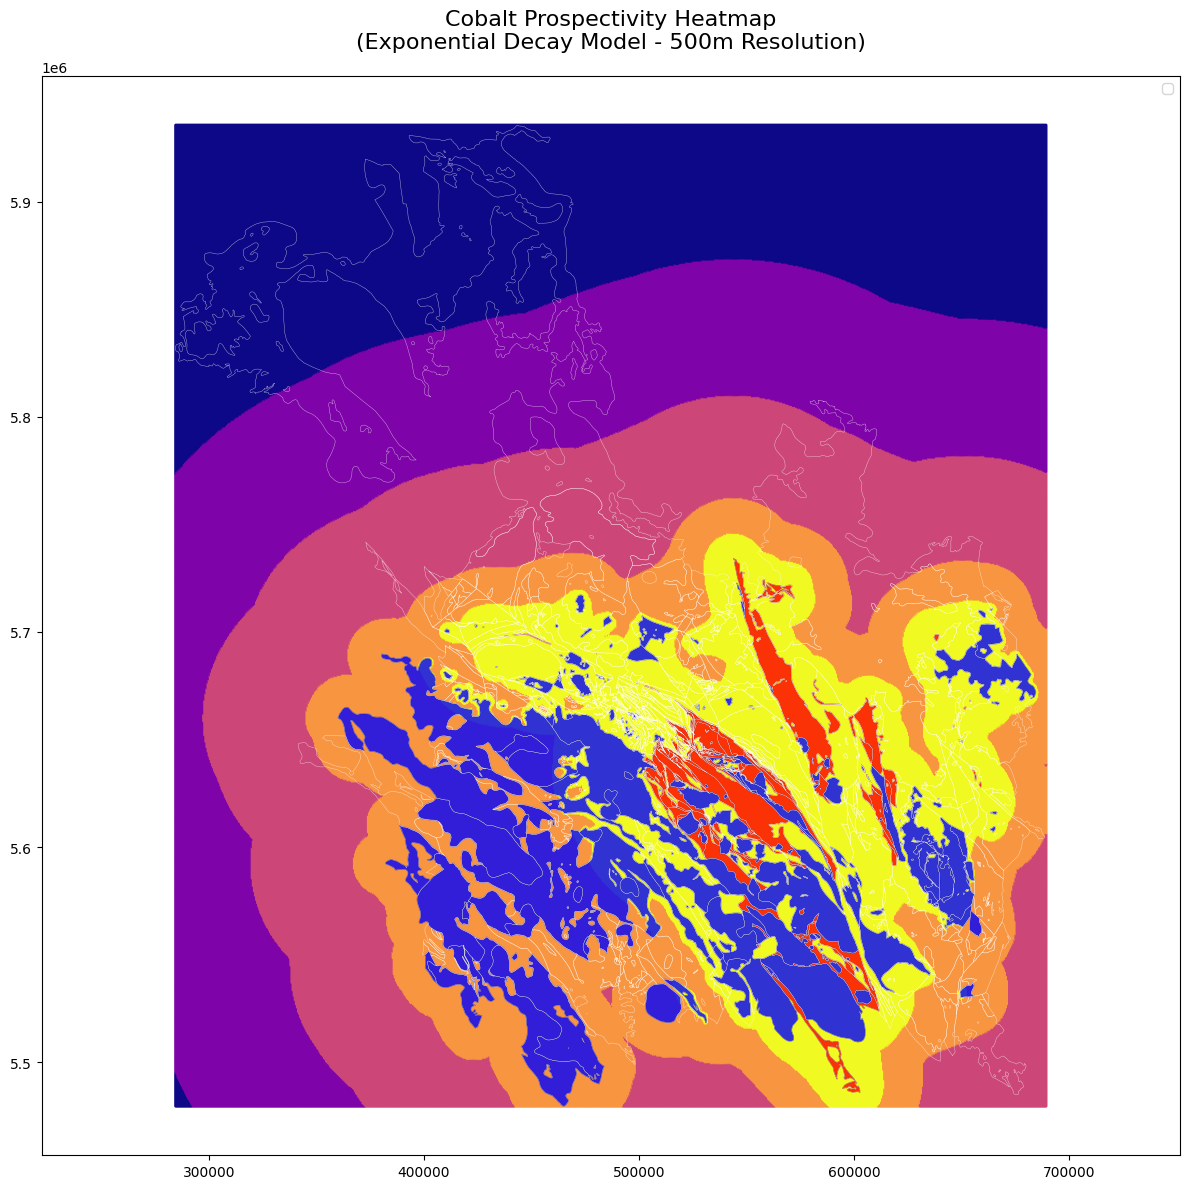


Score Statistics:
count    7.395300e+05
mean     5.799165e-01
std      8.027433e-01
min      3.597065e-08
25%      7.978709e-04
50%      9.311157e-02
75%      1.006048e+00
max      2.999994e+00
Name: cobalt_score, dtype: float64
Unique values: 739530
Grid points: 739530


In [17]:
# ------------------------------------------------------------------
# 8. Improved visualization
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 12))  # Larger figure for better detail
grid.plot(
    column="cobalt_score",
    ax=ax,
    cmap="plasma",           # Better contrast colormap
    markersize=1,            # Smaller markers for higher resolution
    scheme="quantiles",
    legend=True
)

# Add geological context
gdf.boundary.plot(ax=ax, color="white", linewidth=0.3, alpha=0.7)

# Highlight target lithologies
if len(gdf[gdf["is_ultramafic"] == 1]) > 0:
    gdf[gdf["is_ultramafic"] == 1].plot(ax=ax, color="red", alpha=0.8, 
                                        edgecolor="darkred", linewidth=0.5, label="Ultramafic")
if len(gdf[gdf["is_granodiorite"] == 1]) > 0:
    gdf[gdf["is_granodiorite"] == 1].plot(ax=ax, color="blue", alpha=0.8, 
                                          edgecolor="darkblue", linewidth=0.5, label="Granodiorite")

ax.set_title("Cobalt Prospectivity Heatmap\n(Exponential Decay Model - 500m Resolution)", 
             fontsize=16, pad=20)
ax.legend(loc='upper right')
plt.axis("equal")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 9. Score distribution analysis
# ------------------------------------------------------------------
print(f"\nScore Statistics:")
print(grid["cobalt_score"].describe())
print(f"Unique values: {grid['cobalt_score'].nunique()}")
print(f"Grid points: {len(grid)}")

C:\Users\chris\AppData\Local\Temp\ipykernel_31932\1144107102.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ultra_union  = gdf[gdf["is_ultramafic"] == 1].geometry.unary_union
C:\Users\chris\AppData\Local\Temp\ipykernel_31932\1144107102.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grano_union  = gdf[gdf["is_granodiorite"] == 1].geometry.unary_union


Successfully used quantile-based classification

Score class distribution:
score_class
0    9344
1    9343
2    9343
3    9343
4    9343
Name: count, dtype: int64


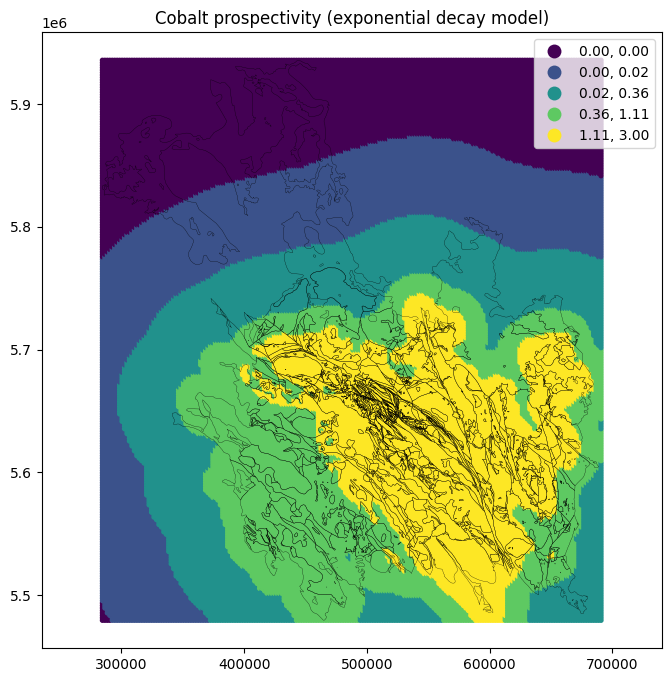


NEW Cobalt Score Statistics:
count    4.671600e+04
mean     5.751544e-01
std      8.002218e-01
min      3.597065e-08
25%      7.684037e-04
50%      9.078189e-02
75%      1.004422e+00
max      2.999989e+00
Name: cobalt_score, dtype: float64

Unique values: 46716
Total points: 46716

Most common scores:
cobalt_score
0.000144    1
0.000154    1
0.000164    1
0.000174    1
0.000185    1
0.000196    1
0.000207    1
0.000218    1
0.000230    1
0.000242    1
Name: count, dtype: int64


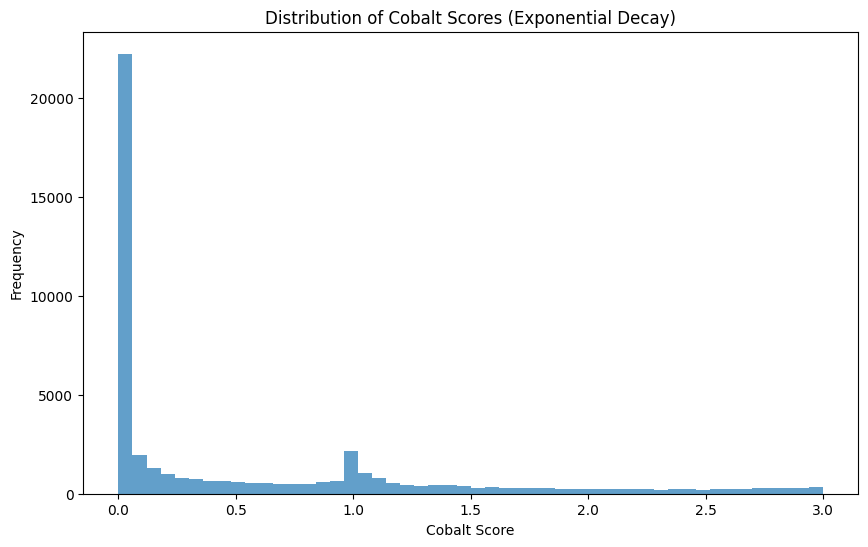

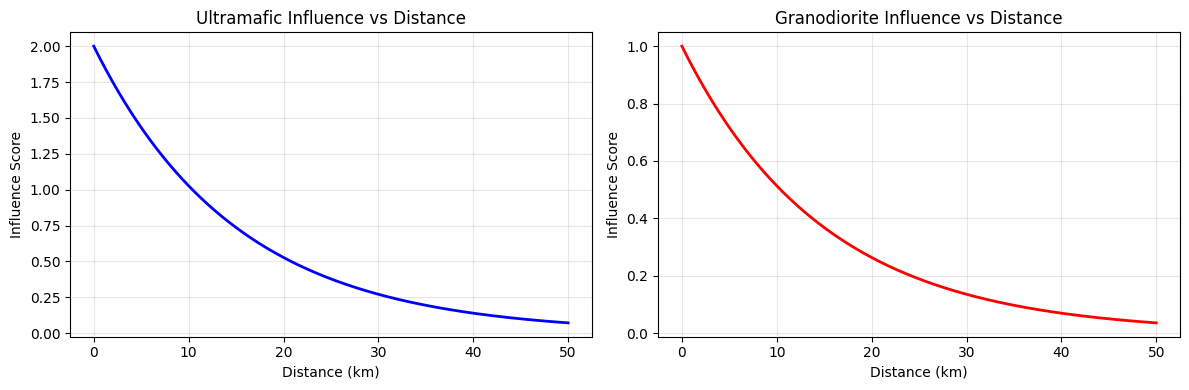

In [15]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0.  PARAMETERS  (edit here)
# ------------------------------------------------------------------
ULTRAMAFIC_WEIGHT   = 2.0      # serpentinised / ultramafic carries most Co signal
GRANODIORITE_WEIGHT = 1.0      # fertile intrusions carry secondary weight
CELL_SIZE_M         = 2_000    # grid resolution (m) → 2 km pixels
DECAY_DISTANCE_M    = 15_000   # distance at which influence decays to ~37% (1/e)
CRS_EQUAL_AREA      = 3978     # NAD83 Canada Albers; swap if you work elsewhere
# ------------------------------------------------------------------

# 1.  Re‑project to an equal‑area CRS for distance work
if gdf.crs is None or gdf.crs.is_geographic:
    gdf = gdf.to_crs(CRS_EQUAL_AREA)

# 2.  Build unified target geometries
ultra_union  = gdf[gdf["is_ultramafic"] == 1].geometry.unary_union
grano_union  = gdf[gdf["is_granodiorite"] == 1].geometry.unary_union

# 3.  Create a fishnet grid that covers the study area
xmin, ymin, xmax, ymax = gdf.total_bounds
xs = np.arange(xmin, xmax + CELL_SIZE_M, CELL_SIZE_M)
ys = np.arange(ymin, ymax + CELL_SIZE_M, CELL_SIZE_M)
grid_points = [Point(x, y) for x in xs for y in ys]
grid = gpd.GeoDataFrame(geometry=grid_points, crs=gdf.crs)

# 4.  Compute distances to each target set (no capping needed with exponential decay)
grid["d_ultra"] = grid.geometry.apply(lambda p: p.distance(ultra_union))
grid["d_grano"] = grid.geometry.apply(lambda p: p.distance(grano_union))

# 5.  Transform distances into scores using exponential decay
#     This provides smooth, continuous scoring without hard cutoffs
grid["s_ultra"] = ULTRAMAFIC_WEIGHT * np.exp(-grid["d_ultra"] / DECAY_DISTANCE_M)
grid["s_grano"] = GRANODIORITE_WEIGHT * np.exp(-grid["d_grano"] / DECAY_DISTANCE_M)

# 6.  Final prospectivity score
grid["cobalt_score"] = grid["s_ultra"] + grid["s_grano"]

# 7.  Classify into quantiles for mapping (now with much better distribution)
try:
    grid["score_class"] = pd.qcut(grid["cobalt_score"], q=5, labels=False)
    print("Successfully used quantile-based classification")
except ValueError as e:
    print(f"Quantile classification failed: {e}")
    print("Falling back to equal-width binning")
    grid["score_class"] = pd.cut(grid["cobalt_score"], bins=5, labels=False)

# Check the class distribution
print("\nScore class distribution:")
print(grid["score_class"].value_counts().sort_index())

# ------------------------------------------------------------------
# 8.  Quick visual sanity‑check
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
grid.plot(column="cobalt_score",
          ax=ax,
          cmap="viridis",
          markersize=8,
          scheme="quantiles",
          legend=True)
gdf.boundary.plot(ax=ax, color="black", linewidth=0.2)
ax.set_title("Cobalt prospectivity (exponential decay model)")
plt.axis("equal")
plt.show()

# ------------------------------------------------------------------
# 9.  Investigate the NEW score distribution
# ------------------------------------------------------------------
print("\nNEW Cobalt Score Statistics:")
print(grid["cobalt_score"].describe())
print(f"\nUnique values: {grid['cobalt_score'].nunique()}")
print(f"Total points: {len(grid)}")

# Check for the most common values
print("\nMost common scores:")
print(grid["cobalt_score"].value_counts().head(10))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(grid["cobalt_score"], bins=50, alpha=0.7)
plt.xlabel("Cobalt Score")
plt.ylabel("Frequency")
plt.title("Distribution of Cobalt Scores (Exponential Decay)")
plt.show()

# Optional: Show the decay curves
plt.figure(figsize=(12, 4))

# Subplot 1: Ultramafic influence
plt.subplot(1, 2, 1)
distances = np.linspace(0, 50000, 1000)
influence = ULTRAMAFIC_WEIGHT * np.exp(-distances / DECAY_DISTANCE_M)
plt.plot(distances/1000, influence, 'b-', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Influence Score')
plt.title('Ultramafic Influence vs Distance')
plt.grid(True, alpha=0.3)

# Subplot 2: Granodiorite influence
plt.subplot(1, 2, 2)
influence = GRANODIORITE_WEIGHT * np.exp(-distances / DECAY_DISTANCE_M)
plt.plot(distances/1000, influence, 'r-', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Influence Score')
plt.title('Granodiorite Influence vs Distance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
##############################################################

In [10]:
`# Step 3: Load rock polygons
rock_a, rock_b = pt.load_bedrock()

SyntaxError: invalid syntax (252669605.py, line 1)

In [ ]:




# Step 4: Build the hexagon grid covering both rock types
grid = pt.build_grid(rock_a, rock_b)

# Step 5: Compute distances to each rock type
grid = pt.add_distance_columns(grid, rock_a, rock_b, crs=pt.settings.crs)

# Step 6: Calculate likelihood scores using the Gaussian kernel
scored = pt.compute_likelihood(grid)

# Step 7: Persist results
out_path = pt.write_parquet(scored)
gdf_cols_description(f"Wrote {len(scored)} H3 cells to {out_path}")

# Step 8: Create an interactive map
html_path = pt.build_map(scored)
gdf_cols_description(f"Saved interactive map to {html_path}")